In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import skimage
import skimage.io
import scipy.io as sio
import skimage.transform
import sys

np.random.seed(0)

VGG_MEAN = [103.939, 116.779, 123.68]

def read_mat(path):
    return np.load(path)

def write_mat(path, m):
    np.save(path, m)

def read_ids(path):
    return [line.rstrip('\n') for line in open(path)]


import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import json
from collections import namedtuple
from tqdm import tqdm
from train_direction import initialize_model

In [4]:
outputChannels = 2
classType = 'unified_CR'
# 0 leaf --> background?
indices = [0]
savePrefix = "direction_" + classType + "_unified_CR_pretrain"
batchSize = 2
learningRate = 1e-5
# learningRateActual = 1e-7
wd = 1e-5
initialIteration = 1

In [5]:
model = initialize_model(outputChannels=outputChannels, wd=wd, modelWeightPaths=None)

In [6]:
from ioUtils import *

In [7]:
trainFeeder = Batch_Feeder(dataset_path="../../watershednet/data/for_training/42/", 
                           indices=indices,
                           subset='train',
                           batchSize=batchSize,
                           padWidth=None,
                           padHeight=None, 
                           flip=False,
                           keepEmpty=False,
                           train=True,
                           img_shape = (384,384))
trainFeeder.set_paths()

scanning ../../watershednet/data/for_training/42/train


In [8]:
trainFeeder._paths[0].angle

'species_42_das_24_image_eve.png.json_slice_angle_0010.npy'

In [12]:
polygons = trainFeeder.polygons[trainFeeder._paths[1].img]['polygons']
ss = trainFeeder.load_mask(np.zeros((384,384,3)), polygons)

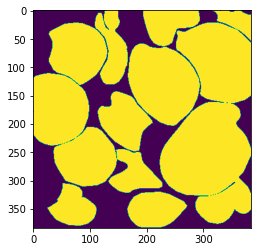

In [13]:
plt.imshow(ss)

In [14]:
valFeeder = Batch_Feeder(dataset_path="../../watershednet/data/for_training/42/", 
                           indices=indices,
                           subset='val',
                           batchSize=batchSize,
                           padWidth=None,
                           padHeight=None, 
                           flip=False,
                           keepEmpty=False,
                           train=True,
                           img_shape = (384,384))
valFeeder.set_paths()

scanning ../../watershednet/data/for_training/42/val


In [15]:
# model, outputChannels, learningRate, trainFeeder, valFeeder, modelSavePath=None, savePrefix=None, initialIteration=1

In [16]:
import direction_model
from ioUtils import *
import math
import lossFunction
import tensorflow as tf
import numpy as np
import sys
import os
import scipy.io as sio
import re
import time

In [ ]:
# with tf.Session() as sess:
#     tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
#     tfBatchGT = tf.placeholder("float", shape=[None, 384, 384, 2])
#     tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])

#     with tf.name_scope("model_builder"):
#         print ("attempting to build model")
#         model.build(tfBatchImages, tfBatchSS)
#         print ("built the model")
        
#     sys.stdout.flush()
#     loss = lossFunction.angularErrorLoss(pred=model.output, gt=tfBatchGT, ss=tfBatchSS, outputChannels=outputChannels)

#     angleError = lossFunction.angularErrorTotal(pred=model.output, gt=tfBatchGT, ss=tfBatchSS, outputChannels=outputChannels)
#     numPredicted = lossFunction.countTotal(ss=tfBatchSS)
#     #numPredictedWeighted = lossFunction.countTotalWeighted(ss=tfBatchSS, weight=tfBatchWeight)
#     exceed45 = lossFunction.exceedingAngleThreshold(pred=model.output, gt=tfBatchGT,
#                                                     ss=tfBatchSS, threshold=45.0, outputChannels=outputChannels)
#     exceed225 = lossFunction.exceedingAngleThreshold(pred=model.output, gt=tfBatchGT,
#                                                     ss=tfBatchSS, threshold=22.5, outputChannels=outputChannels)

#     train_op = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(loss=loss)

#     init = tf.initialize_all_variables()

#     sess.run(init)
#     iteration = initialIteration
    
    
#     while iteration < 1000:
#         batchLosses = []
#         totalAngleError = 0
#         totalExceed45 = 0
#         totalExceed225 = 0
#         totalPredicted = 0

#         for k in tqdm(range(int(math.floor(valFeeder.total_samples() / batchSize)))):
#             imageBatch, gtBatch, ssBatch = valFeeder.next_batch()

#             batchLoss, batchAngleError, batchPredicted, batchExceed45, batchExceed225 = sess.run(
#                 [loss, angleError, numPredicted, exceed45, exceed225],
#                 feed_dict={tfBatchImages: imageBatch,
#                            tfBatchGT: gtBatch,
#                            tfBatchSS: ssBatch})
#             # print "ran iteration"
#             batchLosses.append(batchLoss)
#             totalAngleError += batchAngleError
#             totalPredicted += batchPredicted
#             totalExceed45 += batchExceed45
#             totalExceed225 += batchExceed225

#         if np.isnan(np.mean(batchLosses)):
#             print ("LOSS RETURNED NaN")
#             sys.stdout.flush()
#             break

#         print ("%s Itr: %d - val loss: %.3f, angle MSE: %.3f, exceed45: %.3f, exceed22.5: %.3f" % (
#             time.strftime("%H:%M:%S"), iteration,
#         float(np.mean(batchLosses)), totalAngleError / totalPredicted,
#         totalExceed45 / totalPredicted, totalExceed225 / totalPredicted))
#         sys.stdout.flush()

#         if (iteration > 0 and iteration % 5 == 0) or checkSaveFlag(modelSavePath):
#             modelSaver(sess, modelSavePath, savePrefix, iteration)

#         for j in range(int(math.floor(trainFeeder.total_samples() / batchSize))):
#             # print "running batch %d"%(j)
#             # sys.stdout.flush()
#             imageBatch, gtBatch, ssBatch = trainFeeder.next_batch()
#             sess.run(train_op, feed_dict={tfBatchImages: imageBatch,
#                                           tfBatchGT: gtBatch,
#                                           tfBatchSS: ssBatch})
#         iteration += 1


In [1]:
!ls

Untitled.ipynb         direction_model.py.bak train_direction.py
__pycache__            ioUtils.py
direction_model.py     lossFunction.py


In [ ]:
train_model(model=model, outputChannels=outputChannels,
                learningRate=learningRate,
                trainFeeder=trainFeeder, valFeeder=valFeeder,
                modelSavePath="./cityscapes/models/direction", savePrefix=savePrefix,
                initialIteration=initialIteration)

In [ ]:


class Batch_Feeder:
    def __init__(self, dataset_path, indices, subset, batchSize, padWidth=None, padHeight=None, flip=False, keepEmpty=True, train=True, img_shape=(384,384)):
        
        assert subset in ['train', 'val', 'test'], "wrong name of subset"
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._dataset_path = dataset_path
        self._indices = indices
        self._subset = subset
        self._train = train
        self._batchSize = batchSize
        self._padWidth = padWidth
        self._padHeight = padHeight
        self._flip = flip
        self._keepEmpty = keepEmpty
        self.img_shape = img_shape
        mask_path = os.path.join(self._dataset_path, 'polygons.json')
        with open(mask_path) as f:
            self.polygons = json.load(f)
        
        # TO DO: implement shuffling
        # TO DO: support batch wise inference
        

    def set_paths(self):
        self.root = os.path.join(self._dataset_path, self._subset)
        print('scanning {}'.format(self.root))
        self._paths = []
        
        imgs = sorted([i for i in os.listdir(self.root) if i.endswith('.png')])
        gt_DT = sorted([i for i in os.listdir(self.root) if i.endswith('.npy') and 'DT' in i])
        gt_angle = sorted([i for i in os.listdir(self.root) if i.endswith('.npy') and 'angle' in i])

#         if self._train:

        # TO DO: support batch wise inference

        entry = namedtuple("gt", "index img angle dt")
        for index, (img, angle, dt) in enumerate(zip(imgs, gt_angle, gt_DT)):
            self._paths.append(entry(index, img, angle, dt))

             

            self.shuffle()
#         else:
#             for id in idList:
#                 self._paths.append([id, imageDir + '/' + id + '_leftImg8bit.png',
#                                     ssDir + '/' + id + '_unified_ss.mat'])

        self._numData = len(self._paths)

        if self._numData < self._batchSize:
            self._batchSize = self._numData

    def shuffle(self):
        np.random.shuffle(self._paths)

    def next_batch(self):
        idBatch = []
        
        imageBatch = np.zeros((self._batchSize, self.img_shape[0], self.img_shape[1], 3), dtype=np.int32)
        gtBatch = np.zeros((self._batchSize,  self.img_shape[0], self.img_shape[1]))
        ssBatch = np.zeros((self._batchSize,  self.img_shape[0], self.img_shape[1]))
        
        tmp = 0
        
        if self._train:
            while(len(idBatch) < self._batchSize):
                
                current_tuple = self._paths[self._index_in_epoch]
                
                rgb = self.load_rgb(os.path.join(self.root, current_tuple.img))
        
                #angle = self.load_npy(os.path.join(self.root, current_tuple.angle))
                dt = self.load_npy(os.path.join(self.root, current_tuple.dt))
                
                polygons = self.polygons[current_tuple.img]['polygons']
                mask = self.load_mask(rgb, polygons)


                imageBatch[tmp] = rgb
                gtBatch[tmp] = dt
                ssBatch[tmp] = mask

                idBatch.append(current_tuple.index)
                
                tmp+=1
                if tmp==self._batchSize-1:
                    tmp=0
                self._index_in_epoch += 1
                
                if self._index_in_epoch == self._numData:
                    self._index_in_epoch = 0
                    self.shuffle()

            if self._flip and np.random.uniform() > 0.5:
                for i in range(len(imageBatch)):
                    for j in range(3):
                        imageBatch[i,:,:,j] = np.fliplr(imageBatch[i,:,:,j])

                    weightBatch[i] = np.fliplr(weightBatch[i])
                    ssBatch[i] = np.fliplr(ssBatch[i])
                    ssMaskBatch[i] = np.fliplr(ssMaskBatch[i])

                    for j in range(2):
                        gtBatch[i,:,:,j] = np.fliplr(gtBatch[i,:,:,j])

                    gtBatch[i,:,:,0] = -1 * gtBatch[i,:,:,0]
            return imageBatch, gtBatch, ssBatch
        else:
            pass
            self._index_in_epoch += self._batchSize
            return imageBatch, ssBatch
        
    def total_samples(self):
        return self._numData

    def image_scaling(self, rgb_in):
        if rgb_in.dtype == np.float32:
            rgb_in = rgb_in*255
        elif rgb_in.dtype == np.uint8:
            rgb_in = rgb_in.astype(np.float32)

        # VGG16 was trained using opencv which reads images as BGR, but skimage reads images as RGB
        rgb_out = np.zeros(rgb_in.shape).astype(np.float32)
        rgb_out[:,:,0] = rgb_in[:,:,2] - VGG_MEAN[2]
        rgb_out[:,:,1] = rgb_in[:,:,1] - VGG_MEAN[1]
        rgb_out[:,:,2] = rgb_in[:,:,0] - VGG_MEAN[0]

        return rgb_out

    def pad(self, data):
        if self._padHeight and self._padWidth:
            if data.ndim == 3:
                npad = ((0,self._padHeight-data.shape[0]),(0,self._padWidth-data.shape[1]),(0,0))
            elif data.ndim == 2:
                npad = ((0, self._padHeight - data.shape[0]), (0, self._padWidth - data.shape[1]))
            padData = np.pad(data, npad, mode='constant', constant_values=0)

        else:
            padData = data

        return padData
    
    
    
    
    @staticmethod
    def load_rgb(path):
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR)
    
    @staticmethod
    def load_mask(img, polygons):
        """
        Transforms polygons of a single image into a 2D binary numpy array
        
        :param img: just to get the corresponding shape of the output array
        :param polygons: - dict
        
        :return mask: numpy array with drawn over and touching polygons
        """
        mask = np.zeros([img.shape[0], img.shape[1]], dtype=np.uint8)
        for curr_pol in polygons:
            cv2.fillPoly(mask, [np.array(curr_pol, 'int32')], 255)
        return mask
    
    @staticmethod
    def load_npy(path):
        with open(path, 'rb') as f:
            depth = np.load(f)
        return depth



In [ ]:
np.zeros((trainFeeder._batchSize, trainFeeder.img_shape[0], trainFeeder.img_shape[1], 3)).shape

In [ ]:
batchSize = 4


In [ ]:

trainFeeder = Batch_Feeder(dataset_path="../../watershednet/data/for_training/42/", 
                           indices=indices,
                           subset='val',
                           batchSize=batchSize,
                           padWidth=None,
                           padHeight=None, 
                           flip=False,
                           keepEmpty=False,
                           train=True,
                           img_shape = (384,384))
trainFeeder.set_paths()

In [ ]:
trainFeeder._numData

In [ ]:
for j in tqdm(range(int(np.floor(trainFeeder.total_samples() / batchSize)))):
    # print "running batch %d"%(j)
    # sys.stdout.flush()
    imageBatch, gtBatch, ssBatch = trainFeeder.next_batch()
    print(imageBatch.shape, gtBatch.shape, ssBatch.shape)

In [ ]:
imageBatch[1].max()

In [ ]:
trainFeeder._index_in_epoch

In [ ]:
np.zeros((trainFeeder._batchSize, trainFeeder.img_shape[0], trainFeeder.img_shape[1]))[0].shape

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
trainFeeder._paths[40].img

In [ ]:
angle_map =trainFeeder.load_npy(os.path.join(trainFeeder.root, trainFeeder._paths[40].angle))
seg_get = trainFeeder.Polygon2Mask2D(angle_map.shape, trainFeeder._paths[40].angle)
plt.imshow(seg_get)

In [ ]:
import scipy.io as sio

In [ ]:
#sio.loadmat('species_38_das_6_image_1.png.json_slice_DT_0013.npy')

In [ ]:
ss = (sio.loadmat(self._paths[self._index_in_epoch][3])['mask']).astype(float)
ssMask = ss
ss = np.sum(ss[:,:,self._indices], 2)

background = np.zeros(ssMask.shape[0:2] + (1,))
ssMask = np.concatenate((ssMask[:,:,[1,2,3,4]], background, ssMask[:,:,[0,5,6,7]]), axis=-1)
ssMask = np.argmax(ssMask, axis=-1)
ssMask = ssMask.astype(float)
ssMask = (ssMask - 4) * 32 # centered at 0, with 0 being background, spaced 32 apart for classes